In [1]:
import numpy as np
import pandas as pd
import glob as glob 
import os
import pathlib
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, peak_widths

import utils
from itertools import groupby
from operator import itemgetter

import re
from collections import defaultdict


def get_air(angle_incident, range_):
    theta_deg = 25
    phi_deg = 16

    theta_rad = np.radians(theta_deg)
    phi_rad = np.radians(phi_deg)

    return (np.pi * range_**2 * theta_rad * phi_rad) / (8 * np.log(2) * np.cos(angle_incident))


def get_sigma0(df,angle_inc): 

    angle_rad = np.radians(angle_inc)
    
    # Paramètres
    threshold = 5e-2  # seuil de dérivée
    min_bins_stable = 5  # nombre minimal de bins consécutifs stables

    usefull_df = df.loc[0.5:10]

    # Calcul de sigma0 instantané
    sigma_raw = (usefull_df['copol'] ** 2) * (usefull_df.index ** 4) / 0.00378227

    # Normalisation par la surface projetée du faisceau
    air = get_air(angle_rad, usefull_df.index.values)
    sigma = sigma_raw / air

    # Calcul du log10 de la somme cumulée
    sigma_cumsum_log = np.log10(np.cumsum(sigma.values))
    
    # Approximation de la dérivée
    dsigma = np.gradient(sigma_cumsum_log)
    
    # Création d’un DataFrame temporaire
    sigma_df = pd.DataFrame({
        'range': sigma.index.values,
        'sigma_log': sigma_cumsum_log,
        'dsigma': dsigma
    })
    
    # Masque binaire : 1 si la dérivée est inférieure au seuil
    stable_mask = np.abs(sigma_df['dsigma'].values) < threshold
    
    # Trouver les groupes d'indices stables
    stable_indices = [i for i, val in enumerate(stable_mask) if val]
    
    # Groupes de consécutifs
    for k, g in groupby(enumerate(stable_indices), lambda x: x[0] - x[1]):
        group = list(map(itemgetter(1), g))
        if len(group) >= min_bins_stable:
            first_stable_idx = group[0]
            stable_value_db = 10 * sigma_df.loc[first_stable_idx, 'sigma_log']
            stable_range = sigma_df.loc[first_stable_idx, 'range']
            # print(f"Valeur stabilisée de Sigma : {stable_value_db:.2f} dB à Range = {stable_range:.3f}")
            break
    else:
        stable_value_db = np.nan
        # print("Pas de stabilisation détectée sur une plage suffisante.")

    return stable_value_db

In [2]:
# Fichiers bruts
file_list = glob.glob('../data/fev/17*')
data = file_list
# Dictionnaires : {angle: chemin}
classic_dict = {}
excav_dict = {}

# Remplissage
for file in file_list:
    match = re.search(r'v_(\d+)deg', file)
    if match:
        angle = int(match.group(1))
        if "excav" in file:
            excav_dict[angle] = file
        else:
            classic_dict[angle] = file

# Angles communs aux deux jeux
common_angles = sorted(set(classic_dict.keys()) & set(excav_dict.keys()))

# Création des listes triées
data_classic = [classic_dict[a] for a in common_angles]
data_excav = [excav_dict[a] for a in common_angles]

In [3]:
print(data_classic)
print(data_excav)

['../data/fev/17GHz_oldlodge_undisturbed_0_v_0deg.txt', '../data/fev/17GHz_oldlodge_undisturbed_0_v_10deg.txt', '../data/fev/17GHz_oldlodge_undisturbed_0_v_20deg.txt', '../data/fev/17GHz_oldLodge_undisturbed_0_v_30deg.txt', '../data/fev/17GHz_oldLodge_undisturbde_0_v_40deg.txt']
['../data/fev/17GHz_oldlodge_excav_0_v_0deg.txt', '../data/fev/17GHz_oldlodge_excav_0_v_10deg.txt', '../data/fev/17GHz_oldlodge_excav_0_v_20deg.txt', '../data/fev/17GHz_oldlodge_excav_0_v_30deg.txt', '../data/fev/17GHz_oldlodge_excav_0_v_40deg.txt']


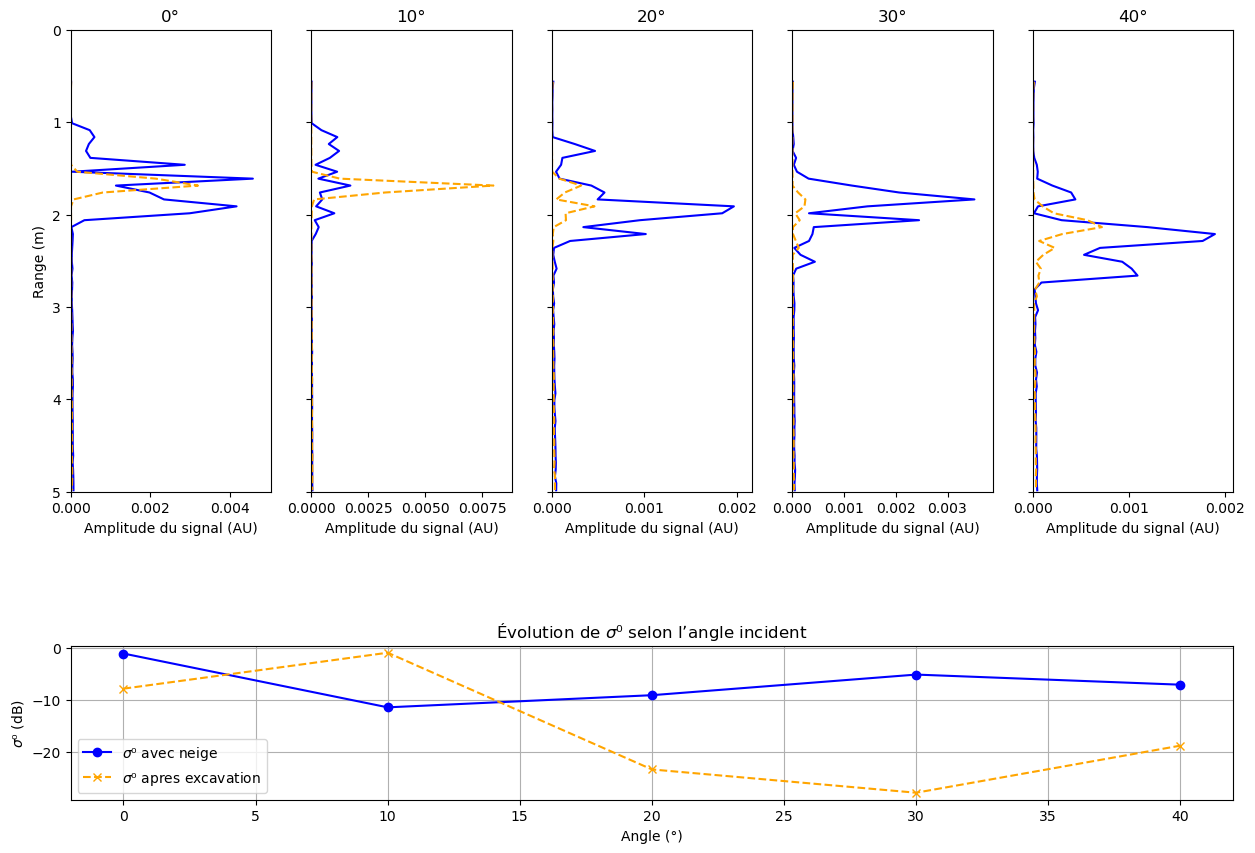

In [4]:

fig = plt.figure(figsize=(15, 10))
gs = fig.add_gridspec(2, len(common_angles), height_ratios=[3, 1], hspace=0.5)

sigma_classic = []
sigma_excav = []

for i, (file_c, file_e, angle) in enumerate(zip(data_classic, data_excav, common_angles)):
    df_c,_ = utils.raw_to_mean_spectrum(file_c, 5)
    df_e,_ = utils.raw_to_mean_spectrum(file_e, 5)

    df_c.index = df_c.index - 0.262
    df_e.index = df_e.index - 0.262

    sigma_classic.append(get_sigma0(df_c,angle))
    sigma_excav.append(get_sigma0(df_e,angle))

    
    df_c = df_c.loc[0.5:5]
    df_e = df_e.loc[0.5:5]
    
    ax = fig.add_subplot(gs[0, i])
    ax.plot(df_c['copol'], df_c.index, label="Classique", color='blue')
    ax.plot(df_e['copol'], df_e.index, label="Excav", color='orange', linestyle='--')
    all_max = max(df_c['copol'].max(), df_e['copol'].max())
    ax.set_xlim(0, all_max * 1.1)  # avec petite marge
    ax.set_ylim(5, 0)  # Pour inverser l’axe Range (0 en haut)
    ax.set_title(f"{angle}°")
    if i == 0:
        ax.set_ylabel("Range (m)")
    else:
        ax.set_yticklabels([])
    ax.set_xlabel("Amplitude du signal (AU)")


# Bas : sigma vs angle
ax_bottom = fig.add_subplot(gs[1, :])
ax_bottom.plot(common_angles, sigma_classic, label='$\sigma$⁰ avec neige', marker='o', color='blue')
ax_bottom.plot(common_angles, sigma_excav, label='$\sigma$⁰ apres excavation', marker='x', linestyle='--', color='orange')
ax_bottom.set_xlabel("Angle (°)")
ax_bottom.set_ylabel("$\sigma$⁰ (dB)")
ax_bottom.set_title("Évolution de $\sigma$⁰ selon l’angle incident")
ax_bottom.grid(True)
ax_bottom.legend()

# plt.tight_layout()
# plt.savefig('oldlodgefevrier.png')
plt.show()